# Exclusive boostDM-CH drivers

### Analysis of CH driver mutations identified by boostDM-CH but not by intersection of the rules 

# 1. Prepare files

In [2]:
import click
import gzip
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
import scipy.stats as stats
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 40)
%precision 2


import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [3]:
### Upload boostDM-CH predictions
Rules_matrix = pd.read_csv('../../../Paper_data/Expert_curated_rules/genes12_BoostdmCH_Harvard_simp_run20230803.tsv.gz', sep='\t')
Rules_matrix['ID2'] = Rules_matrix['chr'].astype(str)+'-'+Rules_matrix['pos'].astype(str)+'-'+ Rules_matrix['alt'].astype(str)
Rules_matrix

,gene,chr,pos,alt,Prot_pos,aachange,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,boostDM_score,boostDM_class,Niroula,Bick,CNIC,WHO,ID2
0,ASXL1,20,32358779,C,2,K2Q,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0,20-32358779-C
1,ASXL1,20,32358779,G,2,K2E,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0,20-32358779-G
2,ASXL1,20,32358779,T,2,K2*,0,1,0,0,0.989503,1,0.0,0.0,0.0,0.0,20-32358779-T
3,ASXL1,20,32358780,C,2,K2T,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0,20-32358780-C
4,ASXL1,20,32358780,G,2,K2R,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0,20-32358780-G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87934,U2AF1,21,43107490,C,2,A2G,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0,21-43107490-C
87935,U2AF1,21,43107490,T,2,A2E,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0,21-43107490-T
87936,U2AF1,21,43107491,A,2,A2S,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0,21-43107491-A
87937,U2AF1,21,43107491,G,2,A2P,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0,21-43107491-G


In [4]:
### Read data ch mutations and age (NOT PROVIDED)
# Created in section 1_Post_processing_calling
patient_age_ch = pd.read_csv('../1_Post_processing_calling/patient_450k_age_670124_ALL_MUTATIONS_20230802_v3.txt.gz',sep="\t")

### Upload general cancer information per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")
ukb200K_ch_cancer = pd.merge(patient_age_ch, patient_cancer,  how='inner', on='patient')

# Upload Cancer variables per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb200k_Siddharta_670124_simple.txt.gz', sep="\t")
patient_cancer = patient_cancer.rename(columns={'eid': 'patient'})
ukb200K_ch_cancer = pd.merge(ukb200K_ch_cancer, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)

# Create a unique variable for hematological cancer
yeears = ['var_MM_years', 'var_MPN_years', 'var_MDS_years', 'var_CMML_years',
          'var_AML_years', 'var_LL_years', 'var_Lymphoma_years', 'var_Myeloma_years']
ukb200K_ch_cancer['var_HNALL_years'] = ukb200K_ch_cancer.loc[:,yeears].min(axis=1)
ukb200K_ch_cancer['var_HNALL_var'] = np.where(ukb200K_ch_cancer['var_HNALL_years'].notnull(), 1, 0)
ukb200K_ch_cancer['var_HNALL_post'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] > 0, 1, 0)
ukb200K_ch_cancer['var_HNALL_pre'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] < 0, 1, 0)

### Upload UKB mutations (NOT PROVIDED)
# Created in section 1_Post_processing_calling
boostDM_predictions = pd.read_csv('../1_Post_processing_calling/All450k_filtered_boostDM_ALL_age_20230802_v3.vcf', sep="\t", compression='gzip')
boostDM_predictions = boostDM_predictions.rename(columns={'case': 'patient', 'BoostDM':'Drivers_12genes'})
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Prot_pos'].isna()]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Consequence'].isin(['start_lost', 'stop_lost', 'stop_retained_variant'])]
boostDM_predictions = boostDM_predictions[boostDM_predictions['patient'].isin(patient_age_ch['patient'])]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['ALT'].str.contains(',')]
len(boostDM_predictions)

/tmp/jobs/jramis/9874679/ipykernel_28636/1437940864.py:7: DtypeWarning: Columns (36,37,38,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")


203351

In [6]:
# Restrict mutations to those in cases without prior hematological cancer
non_HN_patients = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]['patient'].tolist()
boostDM_predictions = boostDM_predictions[boostDM_predictions['patient'].isin(non_HN_patients)]
len(boostDM_predictions)

201857

In [7]:
#Select CH drivers by different methods
BoostDM_dirvers = Rules_matrix[Rules_matrix['boostDM_class']==1]
Niroula_dirvers = Rules_matrix[Rules_matrix['Niroula']==1]
Bick_dirvers = Rules_matrix[Rules_matrix['Bick']==1]
WHO_dirvers = Rules_matrix[Rules_matrix['WHO']==1]

boostDM_predictions['BoostDM'] = np.where(boostDM_predictions['ID2'].isin(BoostDM_dirvers['ID2'].to_list()), 1, 0)
print('BoostDM_Done')
boostDM_predictions['Niroula'] = np.where(boostDM_predictions['ID2'].isin(Niroula_dirvers['ID2'].to_list()), 1, 0)
print('Niroula_Done')
boostDM_predictions['Bick'] = np.where(boostDM_predictions['ID2'].isin(Bick_dirvers['ID2'].to_list()), 1, 0)
print('Bick_Done')
boostDM_predictions['WHO'] = np.where(boostDM_predictions['ID2'].isin(WHO_dirvers['ID2'].to_list()), 1, 0)
print('WHO_Done')

BoostDM_Done
Niroula_Done
Bick_Done
WHO_Done


In [9]:
# Remove cases with previous hematological malignancies
ukb200K_ch_cancer = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0].reset_index(drop=True)
len(ukb200K_ch_cancer)

467202

# Important, this should be removed in order to see also mutations in MDM4 and CHEK2

In [8]:
boostDM_predictions = boostDM_predictions[~boostDM_predictions['SYMBOL'].isin(['MDM4', 'CHEK2'])].reset_index(drop=True)
len(boostDM_predictions)

184379

In [9]:
# Generate different datasets depending on the status as driver by boostDM-CH and the expert curated rules

ukb_Overlap_all = boostDM_predictions[(boostDM_predictions['Niroula']==1)&\
                                    (boostDM_predictions['Bick']==1)&\
                                    (boostDM_predictions['WHO']==1)]['ID2'].to_list()
boostDM_predictions['Intersect_rules'] = np.where(boostDM_predictions['ID2'].isin(ukb_Overlap_all), 1, 0)

ukb_boostDM_exc = boostDM_predictions[(boostDM_predictions['BoostDM']==1)&(boostDM_predictions['Intersect_rules']==0)]['ID2'].to_list()
boostDM_predictions['BoostDM_exc'] = np.where(boostDM_predictions['ID2'].isin(ukb_boostDM_exc), 1, 0)

ukb_Niroula_exc = boostDM_predictions[(boostDM_predictions['BoostDM']==0)&(boostDM_predictions['Intersect_rules']==1)]['ID2'].to_list()
boostDM_predictions['Intersect_exc'] = np.where(boostDM_predictions['ID2'].isin(ukb_Niroula_exc), 1, 0)

ukb_Niroula_exc = boostDM_predictions[(boostDM_predictions['BoostDM']==1)&(boostDM_predictions['Intersect_rules']==1)]['ID2'].to_list()
boostDM_predictions['Intersect_boostDM'] = np.where(boostDM_predictions['ID2'].isin(ukb_Niroula_exc), 1, 0)

ukb_boostDM_exc = boostDM_predictions[(boostDM_predictions['Niroula']==1)&(boostDM_predictions['Intersect_rules']==0)]['ID2'].to_list()
boostDM_predictions['Niroula_exc'] = np.where(boostDM_predictions['ID2'].isin(ukb_boostDM_exc), 1, 0)

ukb_boostDM_exc = boostDM_predictions[(boostDM_predictions['Bick']==1)&(boostDM_predictions['Intersect_rules']==0)]['ID2'].to_list()
boostDM_predictions['Bick_exc'] = np.where(boostDM_predictions['ID2'].isin(ukb_boostDM_exc), 1, 0)

ukb_boostDM_exc = boostDM_predictions[(boostDM_predictions['WHO']==1)&(boostDM_predictions['Intersect_rules']==0)]['ID2'].to_list()
boostDM_predictions['WHO_exc'] = np.where(boostDM_predictions['ID2'].isin(ukb_boostDM_exc), 1, 0)


In [10]:
#Select mutations based on driver call

patients_CHdrivers_Intersect = boostDM_predictions[boostDM_predictions['Intersect_boostDM'] == 1]['patient'].to_list()
patients_CHdrivers_Inter_exc = boostDM_predictions[boostDM_predictions['Intersect_exc'] == 1]['patient'].to_list()
patients_CHdrivers_Boost = boostDM_predictions[boostDM_predictions['BoostDM_exc'] == 1]['patient'].to_list()
patients_CHdrivers_Niroula = boostDM_predictions[boostDM_predictions['Niroula_exc'] == 1]['patient'].to_list()
patients_CHdrivers_Bick = boostDM_predictions[boostDM_predictions['Bick_exc'] == 1]['patient'].to_list()
patients_CHdrivers_WHO = boostDM_predictions[boostDM_predictions['WHO_exc'] == 1]['patient'].to_list()

ukb200K_ch_cancer['Potentiall_all'] = np.where(ukb200K_ch_cancer['patient'].isin(boostDM_predictions['patient'].to_list()), 1, 0)
ukb200K_ch_cancer['Intersect_boostDM'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_Intersect), 1, 0)
ukb200K_ch_cancer['Intersect_exc'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_Inter_exc), 1, 0)
ukb200K_ch_cancer['BoostDM_exc'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_Boost), 1, 0)
ukb200K_ch_cancer['Niroula_exc'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_Niroula), 1, 0)
ukb200K_ch_cancer['Bick_exc'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_Bick), 1, 0)
ukb200K_ch_cancer['WHO_exc'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_WHO), 1, 0)

ukb200K_ch_cancer['Potentiall_all'].value_counts()

0    332215
1    137665
Name: Potentiall_all, dtype: int64

In [11]:
ukb200K_ch_cancer = ukb200K_ch_cancer.rename(columns = {'31-0.0':'sex',
                                                                          '22009-0.1':'PC1',
                                                                          '22009-0.2':'PC2',
                                                                          '22009-0.3':'PC3',
                                                                          '22009-0.4':'PC4',
                                                                          '22009-0.5':'PC5',
                                                                          '22009-0.6':'PC6',
                                                                          '22009-0.7':'PC7',
                                                                          '22009-0.8':'PC8',
                                                                          '22009-0.9':'PC9',
                                                                          '22009-0.10':'PC10',
                                                                         })

In [12]:
genes12 = ['DNMT3A', 'TET2', 'ASXL1', 'CHEK2', 'TP53', 'PPM1D', 'SF3B1', 'SRSF2','U2AF1', 'GNAS','IDH2', 'MDM4']
genes10 = ['DNMT3A', 'TET2', 'ASXL1', 'TP53', 'PPM1D', 'SF3B1', 'SRSF2','U2AF1', 'GNAS','IDH2']

In [13]:
# Exclude individuals with more than one CH driver mutations
ukb200K_ch_cancer = ukb200K_ch_cancer[ukb200K_ch_cancer['num_CH_potential']<2].reset_index(drop=True)
# Exclude cases with previous hematological cancer
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0].reset_index(drop=True)

## 2. New analysis of exclusive boostDM-CH driver mutations

## 2.1 Age associations

In [14]:
agegroups_all_group = ukb200K_ch_cancer_logistic.groupby('age_group_x').size()
agegroups_all_group

age_group_x
38-45     56117
46-50     58650
51-55     68398
56-60     84778
61-65    102094
66-72     62519
dtype: int64

In [15]:
# CH by BosstDM-CH prediction
def prop_CH_model_gender(data, normalize=False, printprop=False):
    
    agegroup_set = data.groupby('age_group_x').size()
    merged = pd.merge(agegroup_set.to_frame(), agegroups_all_group.to_frame(),left_index=True, right_index=True)
    prop_CH = round(merged.apply(lambda x: x['0_x'] / x['0_y'] * 100, axis=1), 4)
    
    if normalize == True:
        prop_CH = prop_CH.apply(lambda x: x / prop_CH[0])
    if printprop == True:
        print(prop_CH)
    return prop_CH

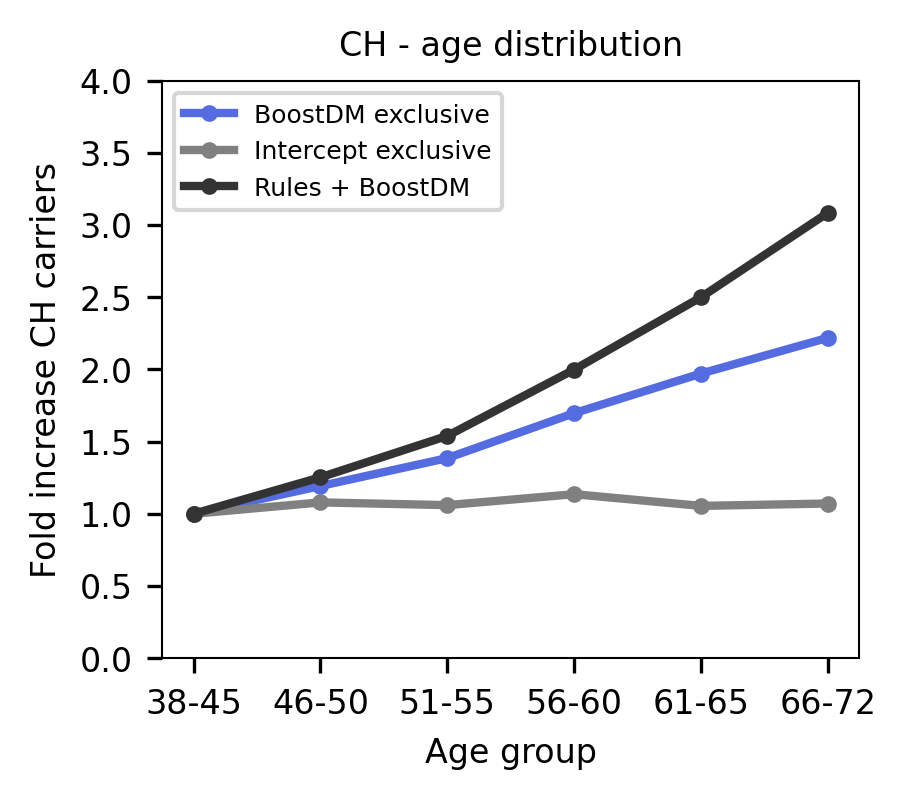

In [16]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 6})
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3,2.5), dpi=300)

age_groups =  ukb200K_ch_cancer_logistic.groupby('age_group_x').size().reset_index().iloc[:,0].tolist()

ukb_boostDM_exc = ukb200K_ch_cancer_logistic[(ukb200K_ch_cancer_logistic['BoostDM_exc']==1)]
agecorr_boostDM_exc = prop_CH_model_gender(ukb_boostDM_exc, normalize=True)

ukb_intercept_exc = ukb200K_ch_cancer_logistic[(ukb200K_ch_cancer_logistic['Intersect_exc']==1)]
agecorr_intercept_exc = prop_CH_model_gender(ukb_intercept_exc, normalize=True)

ukb_Overlap_all = ukb200K_ch_cancer_logistic[(ukb200K_ch_cancer_logistic['Intersect_boostDM']==1)]
agecorr_Overlap_all = prop_CH_model_gender(ukb_Overlap_all, normalize=True)

plt.plot(agecorr_boostDM_exc, '.-', linewidth=2, color='#556CE0')
plt.plot(agecorr_intercept_exc, '.-', linewidth=2, color='grey')
plt.plot(agecorr_Overlap_all, '.-', linewidth=2, color='#333333')

plt.title('CH - age distribution', fontsize = 8)
plt.xlabel('Age group',size=8)
plt.ylabel('Fold increase CH carriers', fontsize=8)
plt.ylim([0,4])
plt.xticks(np.arange(6), age_groups, size=6)

plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
    
plt.legend(['BoostDM exclusive', 'Intercept exclusive', 'Rules + BoostDM'], fontsize=6, loc='upper left')


In [17]:
color_dic = {'BoostDM_exc':'#556CE0',
             'Niroula_exc':'#82678E',
             'Bick_exc':'#6DAC67',
             'WHO_exc':'#EAD36E',
             'Overlap_all':'#333333',
             'Overlapping_2':'#555555',
             'Overlapping_1':'grey'
            }

In [18]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
num_muts = []  
for gene in ['Intersect_boostDM', 'BoostDM_exc', 'Intersect_exc']:   
    #we have exclude pre hematological cases
    CH_driver_matrix = ukb200K_ch_cancer_logistic[(ukb200K_ch_cancer_logistic[gene]==1)|(ukb200K_ch_cancer_logistic['Potentiall_all']==0)]
    model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
    num_mut = len(CH_driver_matrix[(CH_driver_matrix[gene] == 1)])

    name.append(gene)
    num_muts.append(num_mut)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    rsquare.append(model_hematopost.prsquared)
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')

varlist = pd.DataFrame(list(zip(name, num_muts, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','num_muts', 'OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.194460
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.089229
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.068369
         Iterations 8


,gene,num_muts,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,Intersect_boostDM,17240,1.049785,1.047589,1.051986,0.000000e+00,0.016620,sig,0.000000e+00
1,BoostDM_exc,6015,1.036601,1.033099,1.040115,2.897236e-96,0.008242,sig,4.345854e-96
2,Intersect_exc,4264,1.004383,1.000588,1.008193,2.356855e-02,0.000722,sig,2.356855e-02


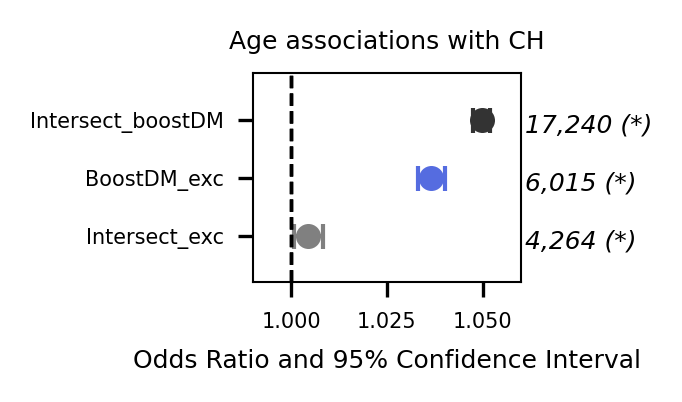

In [19]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(2.6, 1.2), dpi=300)
xlimit = 1.06
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'] == 'Intersect_boostDM':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#333333', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#333333", mec="#333333")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'BoostDM_exc':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#556CE0", mec="#556CE0")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'Intersect_exc':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    if row['sig'] == 'sig':
        ax.text(xlimit+0.001, ylimit-idx-0.2, f"{row['num_muts']:,} (*)", style='italic', size=6)
    else:
        ax.text(xlimit+0.001, ylimit-idx-0.2, str(row['num_muts'])+' (ns)', style='italic', size=6)
        
        
ax.set_title('Age associations with CH', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.99, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)


plt.show()

## 2.2 Gene specific age associations

In [24]:
def gene_matrix(mat, gene):
    if gene == 'ASXL1':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'CHEK2':
        matrix = mat[(mat['ASXL1_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'DNMT3A':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'GNAS':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'IDH2':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'MDM4':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'PPM1D':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'SF3B1':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'SRSF2':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'TET2':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'TP53':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'U2AF1':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['ASXL1_potential']==0)]
    return matrix

### TET2 age associations

In [25]:
# Check TET2 mutations
boostDM_pred_miss = boostDM_predictions[(boostDM_predictions['Consequence']=='missense_variant')&\
                                       (boostDM_predictions['SYMBOL']=='TET2')].reset_index(drop=True)
boostDM_predictions.Consequence.value_counts()

missense_variant                            166321
stop_gained                                  14574
missense_variant&splice_region_variant        2207
splice_region_variant&synonymous_variant      1066
stop_gained&splice_region_variant              211
Name: Consequence, dtype: int64

In [26]:
AA_1104_1481 = boostDM_pred_miss[(boostDM_pred_miss['Prot_pos']>=1104)&\
                                    (boostDM_pred_miss['Prot_pos']<=1481)&\
                                    (boostDM_pred_miss['BoostDM']==1)]['patient'].to_list()
ukb200K_ch_cancer['AA_1104_1481'] = np.where(ukb200K_ch_cancer['patient'].isin(AA_1104_1481), 1, 0)

AA_1482_1842 = boostDM_pred_miss[(boostDM_pred_miss['Prot_pos']<=1842)&\
                                    (boostDM_pred_miss['Prot_pos']>1481)&\
                                    (boostDM_pred_miss['BoostDM']==1)]['patient'].to_list()
ukb200K_ch_cancer['AA_1482_1842'] = np.where(ukb200K_ch_cancer['patient'].isin(AA_1482_1842), 1, 0)

AA_1843_2002 = boostDM_pred_miss[(boostDM_pred_miss['Prot_pos']>=1843)&\
                                    (boostDM_pred_miss['Prot_pos']<=2002)&\
                                    (boostDM_pred_miss['BoostDM']==1)]['patient'].to_list()
ukb200K_ch_cancer['AA_1843_2002'] = np.where(ukb200K_ch_cancer['patient'].isin(AA_1843_2002), 1, 0)

AA_301_1103 = boostDM_pred_miss[(boostDM_pred_miss['Prot_pos']<=1103)&\
                                    (boostDM_pred_miss['Prot_pos']>300)&\
                                    (boostDM_pred_miss['BoostDM']==1)]['patient'].to_list()
ukb200K_ch_cancer['AA_301_1103'] = np.where(ukb200K_ch_cancer['patient'].isin(AA_301_1103), 1, 0)

AA_1_300 = boostDM_pred_miss[(boostDM_pred_miss['Prot_pos']>=1)&\
                                    (boostDM_pred_miss['Prot_pos']<=300)&\
                                    (boostDM_pred_miss['BoostDM']==1)]['patient'].to_list()
ukb200K_ch_cancer['AA_1_300'] = np.where(ukb200K_ch_cancer['patient'].isin(AA_1_300), 1, 0)

ukb200K_ch_cancer['Out_domains'] = np.where(ukb200K_ch_cancer['patient'].isin(AA_1_300+AA_1482_1842+AA_301_1103), 1, 0)

Nonsense = boostDM_predictions[(boostDM_predictions['Consequence']=='stop_gained')&\
                                    (boostDM_predictions['BoostDM']==1)&\
                            (boostDM_predictions['SYMBOL']=='TET2')]['patient'].to_list()
ukb200K_ch_cancer['Nonsense'] = np.where(ukb200K_ch_cancer['patient'].isin(Nonsense), 1, 0)

# ukb_Niroula_exc = ukb200K_ch_cancer[(ukb200K_ch_cancer['BoostDM_CH_driver']==0)&(ukb200K_ch_cancer['Intersect_rules']==1)]['patient'].to_list()
# ukb200K_ch_cancer['Intersect_exc'] = np.where(ukb200K_ch_cancer['patient'].isin(ukb_Niroula_exc), 1, 0)

# ukb_Niroula_exc = ukb200K_ch_cancer[(ukb200K_ch_cancer['BoostDM_CH_driver']==1)&(ukb200K_ch_cancer['Intersect_rules']==1)]['patient'].to_list()
# ukb200K_ch_cancer['Intersect_boostDM'] = np.where(ukb200K_ch_cancer['patient'].isin(ukb_Niroula_exc), 1, 0)


In [27]:
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0].reset_index(drop=True)
len(ukb200K_ch_cancer_logistic)

432556

In [28]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
num_muts = []

ggg = 'TET2'

for gene in ['AA_1_300', 'AA_301_1103', 'AA_1104_1481', 'AA_1482_1842', 'AA_1843_2002', 'Nonsense']:   
    #we have exclude pre hematological cases
    CH_driver_matrix = ukb200K_ch_cancer_logistic[(ukb200K_ch_cancer_logistic[gene]==1)|(ukb200K_ch_cancer_logistic['Potentiall_all']==0)]
    CH_driver_matrix = gene_matrix(CH_driver_matrix, ggg)
    num_mut = len(CH_driver_matrix[(CH_driver_matrix[gene] == 1)])
    if num_mut > 0:
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()

        name.append(gene)
        num_muts.append(num_mut)
        OR.append(np.exp(model_hematopost.params[1]))
        cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
        ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
        rsquare.append(model_hematopost.prsquared)
        pval.append(model_hematopost.pvalues[1])
        sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
    else:
        name.append(gene)
        num_muts.append(num_mut)
        OR.append(np.nan)
        cilow.append(np.nan)
        ciup.append(np.nan)
        rsquare.append(np.nan)
        pval.append(np.nan)
        sig.append(np.nan)

varlist = pd.DataFrame(list(zip(name, num_muts, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','num_muts' , 'OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])

import math
q_value = []
q_val = mtc.fdrcorrection(pd.to_numeric(varlist[~varlist['pval'].isna()]['pval']))[1]
num_pval = -1
for x in varlist.pval:
    if math.isnan(x):
        q_value.append(np.nan)
    else:
        num_pval=num_pval+1
        q_value.append(q_val[num_pval])
varlist["q_value"] = q_value
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' if qval > 0.05 else np.nan for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.000741
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.002785
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.035216
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.003933
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.024125
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.038792
         Iterations 10


,gene,num_muts,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,AA_1_300,23,0.994097,0.945133,1.045598,8.183011e-01,0.024493,ns,8.183011e-01
1,AA_301_1103,99,1.006190,0.981674,1.031318,6.239164e-01,0.011486,ns,7.486996e-01
2,AA_1104_1481,1861,1.036772,1.030548,1.043034,6.736688e-32,0.011267,sig,2.021006e-31
3,AA_1482_1842,146,1.005524,0.985295,1.026168,5.952429e-01,0.010961,ns,7.486996e-01
4,AA_1843_2002,1173,1.022227,1.014695,1.029816,5.686612e-09,0.003736,sig,1.137322e-08
5,Nonsense,2087,1.046814,1.040711,1.052953,4.488654e-53,0.010638,sig,2.693192e-52


In [29]:
import pandas as pd

varlist

# Create an empty row with NaN values
empty_row = pd.Series(['', np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan], index=varlist.columns)
varlist = pd.concat([varlist.iloc[:-1], pd.DataFrame([empty_row]), varlist.iloc[-1:]]).reset_index(drop=True)
varlist


,gene,num_muts,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,AA_1_300,23.0,0.994097,0.945133,1.045598,8.183011e-01,0.024493,ns,8.183011e-01
1,AA_301_1103,99.0,1.006190,0.981674,1.031318,6.239164e-01,0.011486,ns,7.486996e-01
2,AA_1104_1481,1861.0,1.036772,1.030548,1.043034,6.736688e-32,0.011267,sig,2.021006e-31
3,AA_1482_1842,146.0,1.005524,0.985295,1.026168,5.952429e-01,0.010961,ns,7.486996e-01
4,AA_1843_2002,1173.0,1.022227,1.014695,1.029816,5.686612e-09,0.003736,sig,1.137322e-08
5,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Nonsense,2087.0,1.046814,1.040711,1.052953,4.488654e-53,0.010638,sig,2.693192e-52


/home/jramis/anaconda3/envs/test/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/jramis/anaconda3/envs/test/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/tmp/jobs/jramis/9874679/ipykernel_28636/2761685972.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


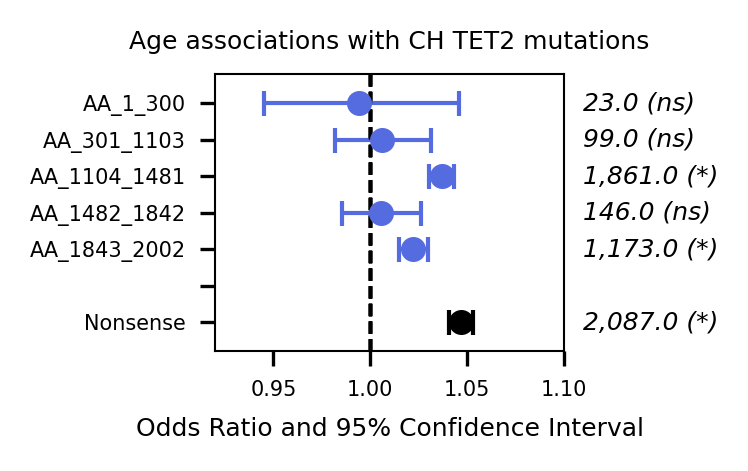

In [30]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(1.5, 1.2), dpi=300)
xlimit = 1.1
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'] == 'Nonsense':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='black', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="black", mec="black")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    else:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#556CE0", mec="#556CE0")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    
        
    if row['sig'] == 'sig':
        ax.text(xlimit+0.01, ylimit-idx-0.2, f"{row['num_muts']:,} (*)", style='italic', size=6)
    elif row['sig'] == 'ns':
        ax.text(xlimit+0.01, ylimit-idx-0.2, f"{row['num_muts']:,} (ns)", style='italic', size=6)
        
        
ax.set_title('Age associations with CH '+ggg+' mutations', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.92, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)


plt.show()

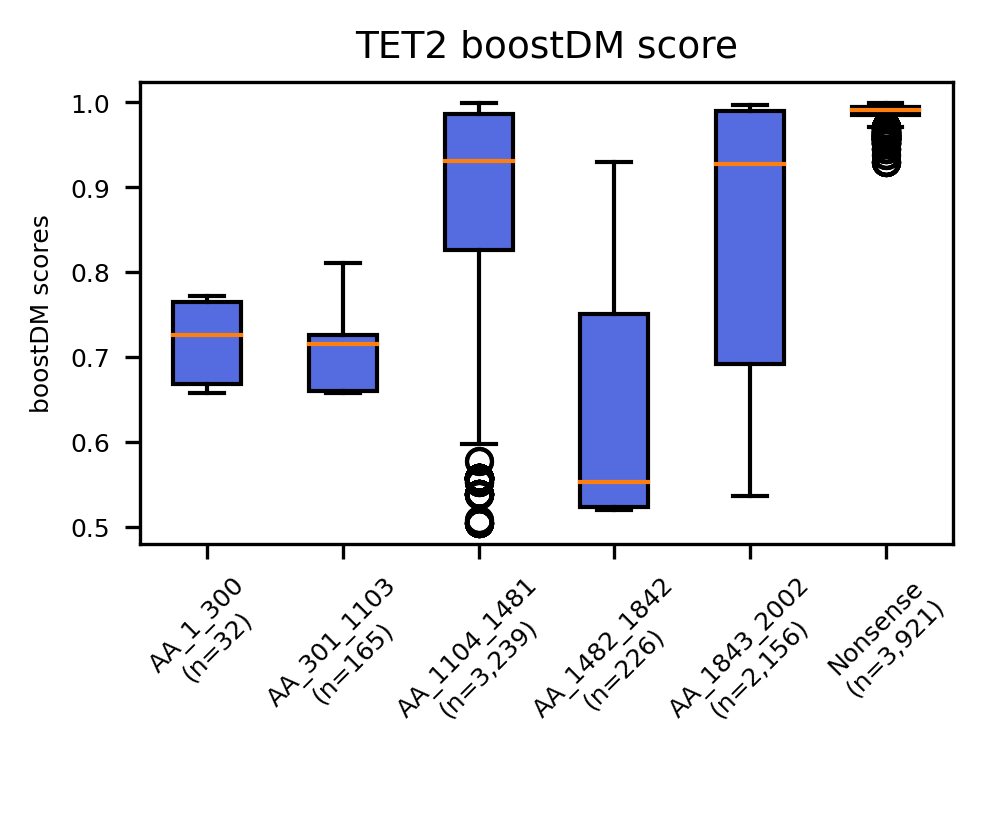

In [31]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3.5, 2), dpi=300)


AA_1104_1481 = boostDM_pred_miss[(boostDM_pred_miss['Prot_pos']>=1104)&\
                                    (boostDM_pred_miss['Prot_pos']<=1481)&\
                                    (boostDM_pred_miss['BoostDM']==1)]['boostDM_score'].to_list()

AA_1843_2002 = boostDM_pred_miss[(boostDM_pred_miss['Prot_pos']>=1843)&\
                                    (boostDM_pred_miss['Prot_pos']<=2002)&\
                                    (boostDM_pred_miss['BoostDM']==1)]['boostDM_score'].to_list()

AA_1_300 = boostDM_pred_miss[(boostDM_pred_miss['Prot_pos']>=1)&\
                                    (boostDM_pred_miss['Prot_pos']<=300)&\
                                    (boostDM_pred_miss['BoostDM']==1)]['boostDM_score'].to_list()

Nonsense = boostDM_predictions[(boostDM_predictions['SYMBOL']=='TET2')&\
                                    (boostDM_predictions['Consequence']=='stop_gained')&\
                                    (boostDM_predictions['BoostDM']==1)]['boostDM_score'].to_list()

AA_1482_1842 = boostDM_pred_miss[(boostDM_pred_miss['Prot_pos']<=1842)&\
                                    (boostDM_pred_miss['Prot_pos']>1481)&\
                                    (boostDM_pred_miss['BoostDM']==1)]['boostDM_score'].to_list()

AA_301_1103 = boostDM_pred_miss[(boostDM_pred_miss['Prot_pos']<=1103)&\
                                    (boostDM_pred_miss['Prot_pos']>300)&\
                                    (boostDM_pred_miss['BoostDM']==1)]['boostDM_score'].to_list()


# Combine the data into a list of lists
data = [AA_1_300, AA_301_1103, AA_1104_1481, AA_1482_1842, AA_1843_2002, Nonsense]

# Create a boxplot
bplot1 = plt.boxplot(data, labels=[f"AA_1_300\n(n={len(AA_1_300):,})", f"AA_301_1103\n(n={len(AA_301_1103):,})",\
                                   f"AA_1104_1481\n(n={len(AA_1104_1481):,})",f"AA_1482_1842\n(n={len(AA_1482_1842):,})",\
                                   f"AA_1843_2002\n(n={len(AA_1843_2002):,})", f"Nonsense\n(n={len(Nonsense):,})"], patch_artist=True)

colors = ['#556CE0', '#556CE0', '#556CE0', '#556CE0', '#556CE0', 'black']
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

# Set labels and title
plt.xlabel(' ',fontsize=6)
plt.ylabel('boostDM scores', fontsize=6)
plt.yticks(fontsize=6)
plt.xticks(fontsize=6, rotation=45)
plt.title('TET2 boostDM score', fontsize=9)

# Show the plot
plt.show()

### TP53 age association

In [32]:
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0].reset_index(drop=True)
len(ukb200K_ch_cancer_logistic)

432556

In [33]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
num_muts = []  

ggg = 'TP53'

for gene in ['Intersect_boostDM', 'BoostDM_exc', 'Intersect_exc']:   
    #we have exclude pre hematological cases
    CH_driver_matrix = ukb200K_ch_cancer_logistic[(ukb200K_ch_cancer_logistic[gene]==1)|(ukb200K_ch_cancer_logistic['Potentiall_all']==0)]
    CH_driver_matrix = gene_matrix(CH_driver_matrix, ggg)
    num_mut = len(CH_driver_matrix[(CH_driver_matrix[gene] == 1)])
    if num_mut > 0:
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
        name.append(gene)
        num_muts.append(num_mut)
        OR.append(np.exp(model_hematopost.params[1]))
        cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
        ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
        rsquare.append(model_hematopost.prsquared)
        pval.append(model_hematopost.pvalues[1])
        sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
    else:
        name.append(gene)
        num_muts.append(np.nan)
        OR.append(np.nan)
        cilow.append(np.nan)
        ciup.append(np.nan)
        rsquare.append(np.nan)
        pval.append(np.nan)
        sig.append(np.nan)

varlist = pd.DataFrame(list(zip(name, num_muts, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','num_muts', 'OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])

import math
q_value = []
q_val = mtc.fdrcorrection(pd.to_numeric(varlist[~varlist['pval'].isna()]['pval']))[1]
num_pval = -1
for x in varlist.pval:
    if math.isnan(x):
        q_value.append(np.nan)
    else:
        num_pval=num_pval+1
        q_value.append(q_val[num_pval])
varlist["q_value"] = q_value
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' if qval > 0.05 else np.nan for qval in varlist.q_value]

    
varlist

Optimization terminated successfully.
         Current function value: 0.016512
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.011652
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.005300
         Iterations 12


,gene,num_muts,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,Intersect_boostDM,754,1.033093,1.023409,1.042869,1.240509e-11,0.005776,sig,3.721527e-11
1,BoostDM_exc,501,1.012635,1.001440,1.023955,2.684888e-02,0.003851,sig,4.027332e-02
2,Intersect_exc,204,0.991120,0.974417,1.008110,3.036937e-01,0.003570,ns,3.036937e-01


/tmp/jobs/jramis/9874679/ipykernel_28636/1956364758.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


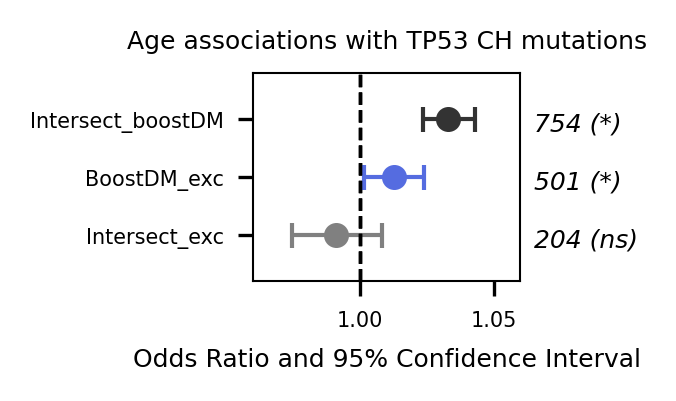

In [34]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(1.15, 0.9), dpi=300)
xlimit = 1.06
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'] == 'Intersect_boostDM':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#333333', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#333333", mec="#333333")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'BoostDM_exc':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#556CE0", mec="#556CE0")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'Intersect_exc':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    if row['sig'] == 'sig':
        ax.text(xlimit+0.005, ylimit-idx-0.2, f"{row['num_muts']:,} (*)", style='italic', size=6)
    else:
        ax.text(xlimit+0.005, ylimit-idx-0.2, str(row['num_muts'])+' (ns)', style='italic', size=6)
        
        
ax.set_title('Age associations with '+ggg+' CH mutations', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.96, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)


plt.show()

### DNMT3A age associations

In [35]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
num_muts = []  

ggg = 'DNMT3A'

for gene in ['Intersect_boostDM', 'BoostDM_exc', 'Intersect_exc']:   
    #we have exclude pre hematological cases
    CH_driver_matrix = ukb200K_ch_cancer_logistic[(ukb200K_ch_cancer_logistic[gene]==1)|(ukb200K_ch_cancer_logistic['Potentiall_all']==0)]
    CH_driver_matrix = gene_matrix(CH_driver_matrix, ggg)
    num_mut = len(CH_driver_matrix[(CH_driver_matrix[gene] == 1)])
    if num_mut > 0:
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
        name.append(gene)
        num_muts.append(num_mut)
        OR.append(np.exp(model_hematopost.params[1]))
        cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
        ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
        rsquare.append(model_hematopost.prsquared)
        pval.append(model_hematopost.pvalues[1])
        sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
    else:
        name.append(gene)
        num_muts.append(np.nan)
        OR.append(np.nan)
        cilow.append(np.nan)
        ciup.append(np.nan)
        rsquare.append(np.nan)
        pval.append(np.nan)
        sig.append(np.nan)

varlist = pd.DataFrame(list(zip(name, num_muts, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','num_muts', 'OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])

import math
q_value = []
q_val = mtc.fdrcorrection(pd.to_numeric(varlist[~varlist['pval'].isna()]['pval']))[1]
num_pval = -1
for x in varlist.pval:
    if math.isnan(x):
        q_value.append(np.nan)
    else:
        num_pval=num_pval+1
        q_value.append(q_val[num_pval])
varlist["q_value"] = q_value
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' if qval > 0.05 else np.nan for qval in varlist.q_value]

    
varlist

Optimization terminated successfully.
         Current function value: 0.122296
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.073815
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.014517
         Iterations 11


,gene,num_muts,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,Intersect_boostDM,8886,1.052201,1.049147,1.055264,5.834327e-258,0.016952,sig,1.750298e-257
1,BoostDM_exc,4605,1.044200,1.040104,1.048312,3.453030e-103,0.011398,sig,5.179546e-103
2,Intersect_exc,650,1.029895,1.019554,1.040341,1.059418e-08,0.005784,sig,1.059418e-08


/tmp/jobs/jramis/9874679/ipykernel_28636/3750207189.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


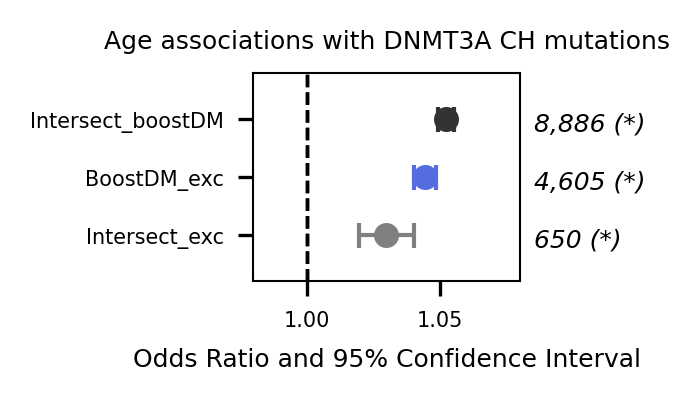

In [36]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(1.15, 0.9), dpi=300)
xlimit = 1.08
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'] == 'Intersect_boostDM':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#333333', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#333333", mec="#333333")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'BoostDM_exc':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#556CE0", mec="#556CE0")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'Intersect_exc':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    if row['sig'] == 'sig':
        ax.text(xlimit+0.005, ylimit-idx-0.2, f"{row['num_muts']:,} (*)", style='italic', size=6)
    else:
        ax.text(xlimit+0.005, ylimit-idx-0.2, str(row['num_muts'])+' (ns)', style='italic', size=6)
        
        
ax.set_title('Age associations with '+ggg+' CH mutations', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.98, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)


plt.show()

### ASXL1 age association

In [37]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
num_muts = []  

ggg = 'ASXL1'

for gene in ['Intersect_boostDM', 'BoostDM_exc', 'Intersect_exc']:   
    #we have exclude pre hematological cases
    CH_driver_matrix = ukb200K_ch_cancer_logistic[(ukb200K_ch_cancer_logistic[gene]==1)|(ukb200K_ch_cancer_logistic['Potentiall_all']==0)]
    CH_driver_matrix = gene_matrix(CH_driver_matrix, ggg)
    num_mut = len(CH_driver_matrix[(CH_driver_matrix[gene] == 1)])
    if num_mut > 0:
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
        name.append(gene)
        num_muts.append(num_mut)
        OR.append(np.exp(model_hematopost.params[1]))
        cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
        ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
        rsquare.append(model_hematopost.prsquared)
        pval.append(model_hematopost.pvalues[1])
        sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
    else:
        name.append(gene)
        num_muts.append(np.nan)
        OR.append(np.nan)
        cilow.append(np.nan)
        ciup.append(np.nan)
        rsquare.append(np.nan)
        pval.append(np.nan)
        sig.append(np.nan)

varlist = pd.DataFrame(list(zip(name, num_muts, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','num_muts', 'OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])

import math
q_value = []
q_val = mtc.fdrcorrection(pd.to_numeric(varlist[~varlist['pval'].isna()]['pval']))[1]
num_pval = -1
for x in varlist.pval:
    if math.isnan(x):
        q_value.append(np.nan)
    else:
        num_pval=num_pval+1
        q_value.append(q_val[num_pval])
varlist["q_value"] = q_value
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' if qval > 0.05 else np.nan for qval in varlist.q_value]

    
varlist

Optimization terminated successfully.
         Current function value: 0.025291
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.003671
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000330
         Iterations 21


,gene,num_muts,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,Intersect_boostDM,1264,1.055846,1.047758,1.063995,1.236833e-43,0.018780,sig,3.710499e-43
1,BoostDM_exc,134,1.014545,0.992938,1.036622,1.886000e-01,0.004172,ns,2.829000e-01
2,Intersect_exc,10,0.996265,0.922843,1.075527,9.236668e-01,0.074433,ns,9.236668e-01


/tmp/jobs/jramis/9874679/ipykernel_28636/1398063652.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


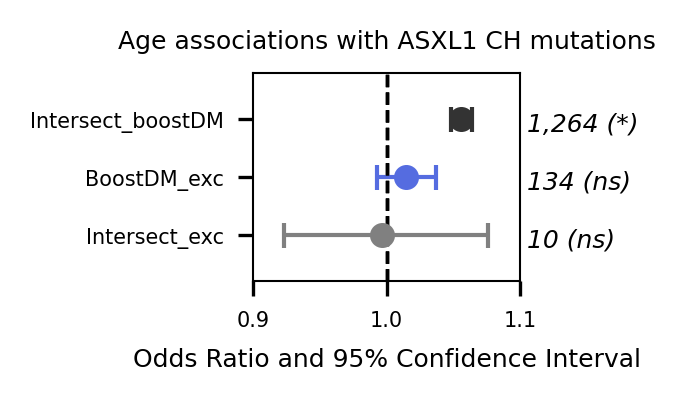

In [38]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(1.15, 0.9), dpi=300)
xlimit = 1.1
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'] == 'Intersect_boostDM':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#333333', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#333333", mec="#333333")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'BoostDM_exc':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#556CE0", mec="#556CE0")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'Intersect_exc':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    if row['sig'] == 'sig':
        ax.text(xlimit+0.005, ylimit-idx-0.2, f"{row['num_muts']:,} (*)", style='italic', size=6)
    else:
        ax.text(xlimit+0.005, ylimit-idx-0.2, str(row['num_muts'])+' (ns)', style='italic', size=6)
        
        
ax.set_title('Age associations with '+ggg+' CH mutations', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.9, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)


plt.show()

## 3. All cause death associations

In [39]:
# NEED TO HAVE SAME INDEX TO ADD COLUMN
covariables = pd.read_csv('../../../Paper_data/UKB_clinic_info/dataframe_cases_covariables_v2.txt.gz',sep="\t")
covariables = covariables[covariables['patient'].isin(ukb200K_ch_cancer['patient'].tolist())]
covariables = covariables.reset_index(drop=True)

/tmp/jobs/jramis/9874679/ipykernel_28636/138586407.py:2: DtypeWarning: Columns (60,294,298,299,302,306,308,310,312,314,316,320,324,326,328,330,336,338,340,346,348,350,352,354,356,362,364,366,368,370,372,374,376,380,382,394,396,398,400,404,406,408,412,414,416,418,420,424,426,428,430,434,436,442,444,446,448,450,454,456,458,464,465,466,467,468,469,472,473,474,475,478,479,480,481,482,483,486,487,488,489,490,491,492,493,496,497,498,499,500,1269,1285,1286,1287,1288,1289,1292,1293,1294,1295,1296,1297,1319) have mixed types. Specify dtype option on import or set low_memory=False.
  covariables = pd.read_csv('../../../Paper_data/UKB_clinic_info/dataframe_cases_covariables_v2.txt.gz',sep="\t")


In [40]:
### Merge
ukb200K_ch_covariables = pd.merge(ukb200K_ch_cancer[['patient']], covariables,  how='inner', on='patient')

In [41]:
import math
ukb200K_ch_cancer['40007-0.0'] = ukb200K_ch_covariables['40007-0.0']
ukb200K_ch_cancer['Death_status'] = ukb200K_ch_covariables['40007-0.0'].apply(lambda x: 0 if math.isnan(x) else 1)
ukb200K_ch_cancer

import math
ukb200K_ch_cancer['Death_status'] = ukb200K_ch_covariables['40007-0.0'].apply(lambda x: 0 if math.isnan(x) else 1)
ukb200K_ch_cancer['Smoking'] = np.where(ukb200K_ch_covariables['20116-0.0_x']==-3, np.nan, ukb200K_ch_covariables['20116-0.0_x'])
ukb200K_ch_cancer['Packages_cigarettes'] = np.where(ukb200K_ch_covariables['20116-0.0_x']==0, 0, ukb200K_ch_covariables['20161-0.0_x']) 

# Removing previous smokers
ukb200K_ch_cancer['Smoking_1'] = np.where(ukb200K_ch_cancer['Smoking']==1, np.nan, ukb200K_ch_cancer['Smoking'])
ukb200K_ch_cancer['Smoking_1'] = np.where(ukb200K_ch_cancer['Smoking_1']==2, 1, ukb200K_ch_cancer['Smoking_1'])
# Togather previous with current smokers
ukb200K_ch_cancer['Smoking_2'] = np.where(ukb200K_ch_cancer['Smoking']==2, 1, ukb200K_ch_cancer['Smoking'])

In [42]:
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0].reset_index(drop=True)
len(ukb200K_ch_cancer_logistic)

432556

In [43]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
num_muts = []  
for gene in ['Intersect_boostDM', 'BoostDM_exc', 'Intersect_exc']:   
    #we have exclude pre hematological cases
    CH_driver_matrix = ukb200K_ch_cancer_logistic[(ukb200K_ch_cancer_logistic[gene]==1)|(ukb200K_ch_cancer_logistic['Potentiall_all']==0)]
    model_hematopost = smf.logit(formula= 'Death_status ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
    num_mut = len(CH_driver_matrix[(CH_driver_matrix[gene] == 1)])

    name.append(gene)
    num_muts.append(num_mut)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    rsquare.append(model_hematopost.prsquared)
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')

varlist = pd.DataFrame(list(zip(name, num_muts, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','num_muts', 'OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.237965
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.234871
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.234055
         Iterations 8


,gene,num_muts,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,Intersect_boostDM,17240,1.246263,1.183680,1.312154,5.523394e-17,0.082042,sig,1.657018e-16
1,BoostDM_exc,6015,1.144539,1.045431,1.253043,3.484711e-03,0.081029,sig,5.227067e-03
2,Intersect_exc,4264,1.053734,0.937063,1.184931,3.820017e-01,0.081196,ns,3.820017e-01


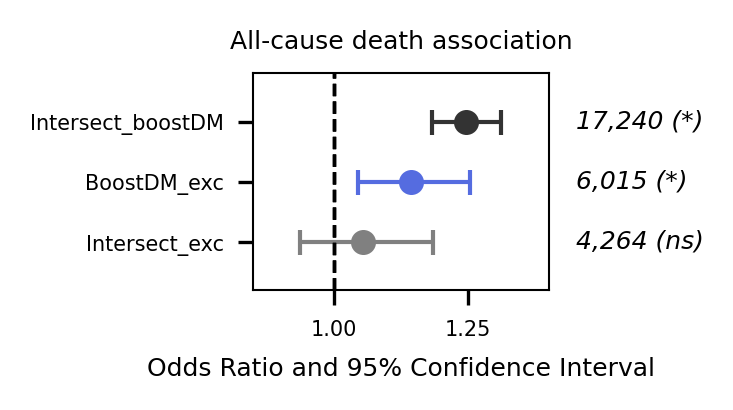

In [254]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(4, 1.4), dpi=300)
xlimit = 1.4
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'] == 'Intersect_boostDM':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#333333', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#333333", mec="#333333")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'BoostDM_exc':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#556CE0", mec="#556CE0")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'Intersect_exc':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    if row['sig'] == 'sig':
        ax.text(xlimit+0.05, ylimit-idx-0.1, f"{row['num_muts']:,} (*)", style='italic', size=6)
    else:
        ax.text(xlimit+0.05, ylimit-idx-0.1, f"{row['num_muts']:,} (ns)", style='italic', size=6)       
        
ax.set_title('All-cause death association', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.85, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)


plt.show()

## 4. Myeloid associations

In [255]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
num_muts = []  
for gene in ['Intersect_boostDM', 'BoostDM_exc', 'Intersect_exc']:   
    #we have exclude pre hematological cases
    CH_driver_matrix = ukb200K_ch_cancer_logistic[(ukb200K_ch_cancer_logistic[gene]==1)|(ukb200K_ch_cancer_logistic['Potentiall_all']==0)]
    model_hematopost = smf.logit(formula= 'var_MM_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_driver_matrix).fit()
    num_mut = len(CH_driver_matrix[(CH_driver_matrix[gene] == 1)])

    name.append(gene)
    num_muts.append(num_mut)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    rsquare.append(model_hematopost.prsquared)
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')

varlist = pd.DataFrame(list(zip(name, num_muts, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','num_muts', 'OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.015652
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.013510
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.013395
         Iterations 11


,gene,num_muts,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,Intersect_boostDM,17240,5.100766,4.331616,6.006490,5.180396e-85,0.053047,sig,1.554119e-84
1,BoostDM_exc,6015,1.819816,1.198458,2.763325,4.962830e-03,0.023525,sig,7.444245e-03
2,Intersect_exc,4264,1.611664,0.929389,2.794804,8.927274e-02,0.022932,ns,8.927274e-02


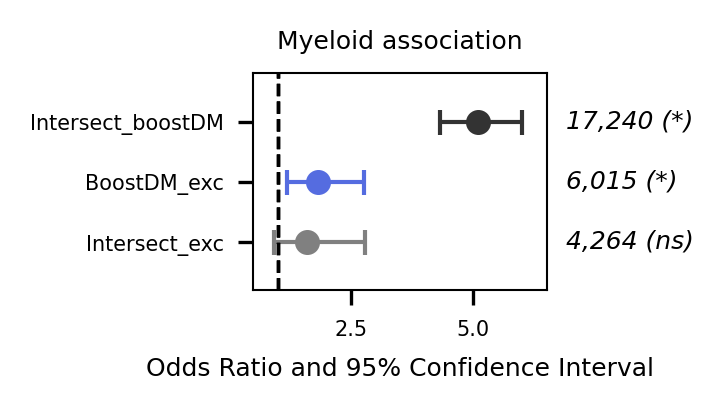

In [257]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3.4, 1.4), dpi=300)
xlimit = 6.5
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'] == 'Intersect_boostDM':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#333333', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#333333", mec="#333333")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'BoostDM_exc':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#556CE0", mec="#556CE0")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'Intersect_exc':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    if row['sig'] == 'sig':
        ax.text(xlimit+0.4, ylimit-idx-0.1, f"{row['num_muts']:,} (*)", style='italic', size=6)
    else:
        ax.text(xlimit+0.4, ylimit-idx-0.1, f"{row['num_muts']:,} (ns)", style='italic', size=6) 
        
        
ax.set_title('Myeloid association', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.5, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)


plt.show()

## 5. Smoking association

In [220]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
num_muts = []  
for gene in ['Intersect_boostDM', 'BoostDM_exc', 'Intersect_exc']:   
    #we have exclude pre hematological cases
    CH_driver_matrix = ukb200K_ch_cancer_logistic[(ukb200K_ch_cancer_logistic[gene]==1)|(ukb200K_ch_cancer_logistic['Potentiall_all']==0)]
    model_hematopost = smf.logit(formula= gene+' ~ 1 + Smoking_2 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
    num_mut = len(CH_driver_matrix[(CH_driver_matrix[gene] == 1)])

    name.append(gene)
    num_muts.append(num_mut)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    rsquare.append(model_hematopost.prsquared)
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')

varlist = pd.DataFrame(list(zip(name, num_muts, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','num_muts', 'OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.194367
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.089259
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.068466
         Iterations 8


,gene,num_muts,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,Intersect_boostDM,17240,1.129533,1.094740,1.165431,2.340698e-14,0.017014,sig,7.022095e-14
1,BoostDM_exc,6015,1.076179,1.021711,1.133551,5.597359e-03,0.008354,sig,8.396038e-03
2,Intersect_exc,4264,1.022350,0.961277,1.087302,4.818527e-01,0.000734,ns,4.818527e-01


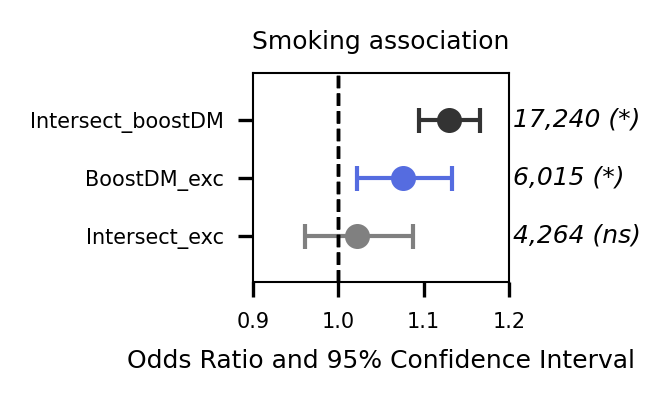

In [221]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(2.6, 1.2), dpi=300)
xlimit = 1.2
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'] == 'Intersect_boostDM':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#333333', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#333333", mec="#333333")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'BoostDM_exc':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#556CE0", mec="#556CE0")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'Intersect_exc':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    if row['sig'] == 'sig':
        ax.text(xlimit+0.005, ylimit-idx-0.1, f"{row['num_muts']:,} (*)", style='italic', size=6)
    else:
        ax.text(xlimit+0.005, ylimit-idx-0.1, f"{row['num_muts']:,} (ns)", style='italic', size=6) 
        
        
ax.set_title('Smoking association', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.9, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)


plt.show()

### ASXL1 associations with smoking

In [222]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
num_muts = []
num_events = []

ggg = 'ASXL1'

for gene in ['Intersect_boostDM', 'BoostDM_exc', 'Intersect_exc']:   
    #we have exclude pre hematological cases
    CH_driver_matrix = ukb200K_ch_cancer_logistic[(ukb200K_ch_cancer_logistic[gene]==1)|(ukb200K_ch_cancer_logistic['Potentiall_all']==0)]
    CH_driver_matrix = gene_matrix(CH_driver_matrix, ggg)
    num_mut = len(CH_driver_matrix[(CH_driver_matrix[gene] == 1)])
    num_event = len(CH_driver_matrix[(CH_driver_matrix[gene] == 1)&(CH_driver_matrix['var_HNALL_post'] == 1)])

    if num_mut > 0:
        model_hematopost = smf.logit(formula= gene+' ~ 1 + Smoking_2 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()

        name.append(gene)
        num_muts.append(num_mut)
        OR.append(np.exp(model_hematopost.params[1]))
        cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
        ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
        rsquare.append(model_hematopost.prsquared)
        num_events.append(num_event)
        pval.append(model_hematopost.pvalues[1])
        sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
    else:
        name.append(gene)
        num_muts.append(num_mut)
        num_events.append(num_event)
        OR.append(np.nan)
        cilow.append(np.nan)
        ciup.append(np.nan)
        rsquare.append(np.nan)
        pval.append(np.nan)
        sig.append(np.nan)

varlist = pd.DataFrame(list(zip(name, num_muts, num_events, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','num_muts' , 'num_events', 'OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])

import math
q_value = []
q_val = mtc.fdrcorrection(pd.to_numeric(varlist[~varlist['pval'].isna()]['pval']))[1]
num_pval = -1
for x in varlist.pval:
    if math.isnan(x):
        q_value.append(np.nan)
    else:
        num_pval=num_pval+1
        q_value.append(q_val[num_pval])
varlist["q_value"] = q_value
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' if qval > 0.05 else np.nan for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.025186
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.003657
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000331
         Iterations 21


,gene,num_muts,num_events,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,Intersect_boostDM,1264,27,1.500330,1.338660,1.681524,3.083952e-12,0.021815,sig,9.251857e-12
1,BoostDM_exc,134,2,1.375118,0.973361,1.942699,7.079109e-02,0.005718,ns,1.061866e-01
2,Intersect_exc,10,0,0.826677,0.227395,3.005319,7.725562e-01,0.074989,ns,7.725562e-01


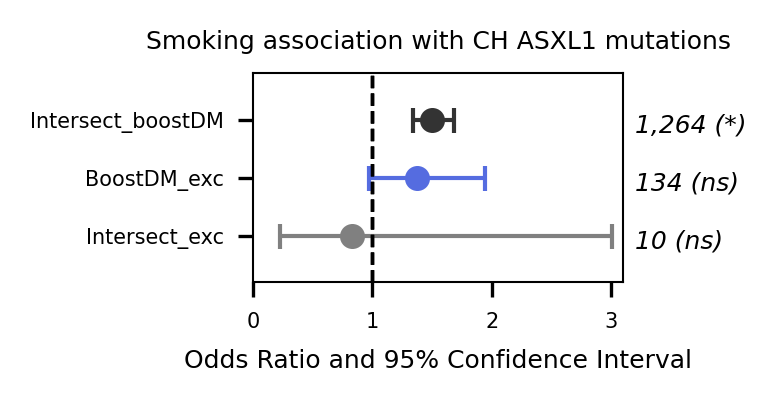

In [223]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(2.7, 1.2), dpi=300)
xlimit = 3.1
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'] == 'Intersect_boostDM':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#333333', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#333333", mec="#333333")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'BoostDM_exc':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#556CE0", mec="#556CE0")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'Intersect_exc':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
                
    if row['sig'] == 'sig':
        ax.text(xlimit+0.1, ylimit-idx-0.2, f"{row['num_muts']:,} (*)", style='italic', size=6)
    else:
        ax.text(xlimit+0.1, ylimit-idx-0.2, f"{row['num_muts']:,} (ns)", style='italic', size=6)
        
        
ax.set_title('Smoking association with CH '+ggg+' mutations', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)


plt.show()

## 6. Experimental outread for mutations

In [53]:
DNMT3A_predictions = boostDM_predictions[boostDM_predictions['SYMBOL']=='DNMT3A']
AA = []
for x in range(len(DNMT3A_predictions)):
    row = DNMT3A_predictions.iloc[x,:]
    AA.append(row['AA_change'].split('/')[0]+row['Prot_pos'].astype('str')[:-2]+row['AA_change'].split('/')[-1])
DNMT3A_predictions['Mutation_list'] = AA

/tmp/jobs/jramis/9759392/ipykernel_28936/305560723.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DNMT3A_predictions['Mutation_list'] = AA


In [44]:
### Annotate with boostDM-CH prediction
DNMT3A_met = pd.read_csv('../../../Paper_data/Experimental_data/DNMT3A/DNMT3A_evaluating_mutations.csv', sep='\t')
DNMT3A_met = DNMT3A_met.iloc[:,4:]
DNMT3A_met

,Mutation_list,sgRNA_score_d9_citrine_positive,Hit_status,boostDM_score,boostDM_pred
0,W698*,1.751051,enriched,0.995337,1
1,E756K,1.635047,enriched,0.744854,1
2,Q527*,1.601537,enriched,0.986471,1
3,L737F,1.598453,enriched,0.979201,1
4,D641N,1.455682,enriched,0.790142,1
...,...,...,...,...,...
151,V626I,-0.257446,unchanged,0.006466,0
152,D781N,-0.298170,unchanged,0.162090,0
153,E505K,-0.388036,unchanged,0.001803,0
154,M585I,-0.397557,unchanged,0.362861,0


In [54]:
DNMT3A_predictions = pd.merge(DNMT3A_predictions, DNMT3A_met, on='Mutation_list', how='right')
len(DNMT3A_predictions)

2423

In [55]:
color_dic = {'BoostDM_exc':'#556CE0',
             'Niroula_exc':'#82678E',
             'Bick_exc':'#6DAC67',
             'WHO_exc':'#EAD36E',
             'Overlap_all':'#333333',
             'Overlapping_2':'#555555',
             'Overlapping_1':'grey'
            }

In [56]:
DNMT3A_predictions[(DNMT3A_predictions['BoostDM_exc']==1)][['ID2', 'sgRNA_score_d9_citrine_positive']].drop_duplicates()['sgRNA_score_d9_citrine_positive']

32      1.635047
77      1.455682
232     1.356938
242     1.343416
298     1.313093
          ...   
1978    0.004308
1983   -0.000862
2040   -0.009280
2159   -0.059215
2270   -0.131719
Name: sgRNA_score_d9_citrine_positive, Length: 41, dtype: float64

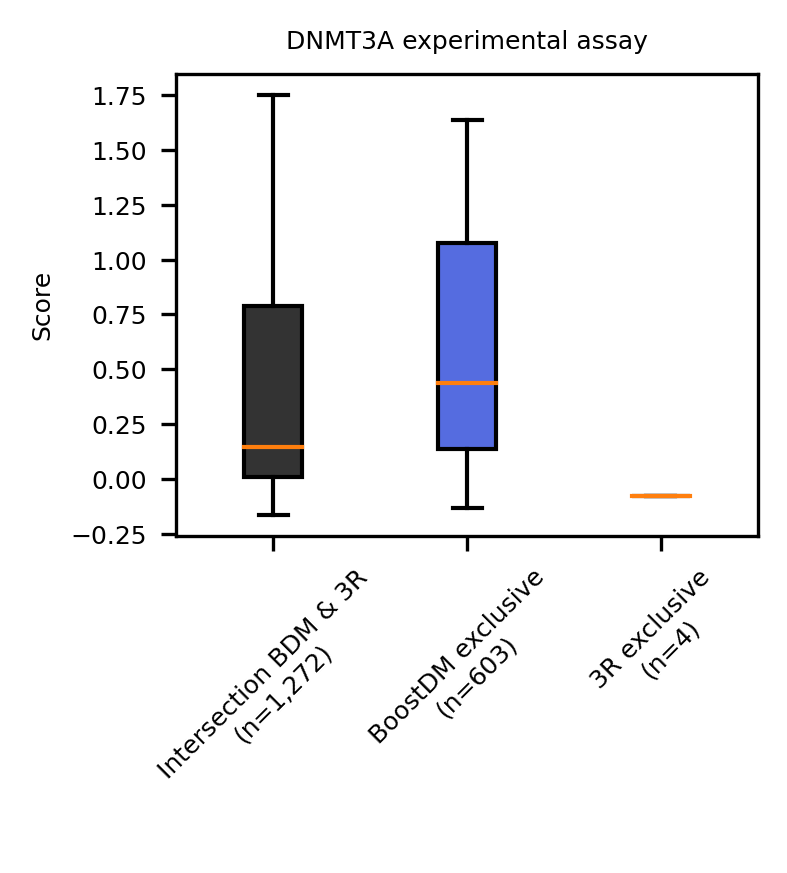

In [57]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(2.5, 2), dpi=300)


ukb_boostDM_exc = DNMT3A_predictions[(DNMT3A_predictions['BoostDM_exc']==1)]['sgRNA_score_d9_citrine_positive'].to_list()
ukb_Niroula_exc = DNMT3A_predictions[(DNMT3A_predictions['Niroula_exc']==1)]['sgRNA_score_d9_citrine_positive'].to_list()
ukb_Bick_exc = DNMT3A_predictions[(DNMT3A_predictions['Bick_exc']==1)]['sgRNA_score_d9_citrine_positive'].to_list()
ukb_WHO_exc = DNMT3A_predictions[(DNMT3A_predictions['WHO_exc']==1)]['sgRNA_score_d9_citrine_positive'].to_list()
ukb_Inter_exc = DNMT3A_predictions[(DNMT3A_predictions['Intersect_exc']==1)]['sgRNA_score_d9_citrine_positive'].to_list()
ukb_Inter_BDM = DNMT3A_predictions[(DNMT3A_predictions['Intersect_boostDM']==1)]['sgRNA_score_d9_citrine_positive'].to_list()


# Combine the data into a list of lists
data = [ukb_Inter_BDM, ukb_boostDM_exc, ukb_Inter_exc]

# Create a boxplot
bplot1 = plt.boxplot(data, labels=[f"Intersection BDM & 3R\n(n={len(ukb_Inter_BDM):,})",\
                                   f"BoostDM exclusive\n(n={len(ukb_boostDM_exc):,})",\
                                   f"3R exclusive\n(n={len(ukb_Inter_exc):,})"], patch_artist=True)

colors = ['#333333', '#556CE0', 'grey']
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

# Set labels and title
plt.title('DNMT3A experimental assay', size =6)
plt.xlabel(' ',fontsize=6)
plt.ylabel('Score', fontsize=6)
plt.yticks(fontsize=6)
plt.xticks(fontsize=6, rotation=45)
# plt.title(' ', fontsize=9)

plt.show()

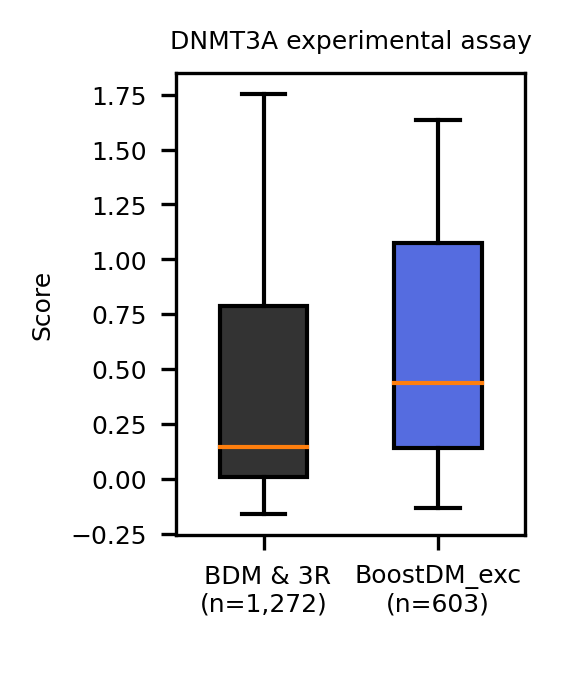

In [58]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(1.5, 2), dpi=300)

ukb_boostDM_exc = DNMT3A_predictions[(DNMT3A_predictions['BoostDM_exc']==1)]['sgRNA_score_d9_citrine_positive'].to_list()
ukb_Niroula_exc = DNMT3A_predictions[(DNMT3A_predictions['Niroula_exc']==1)]['sgRNA_score_d9_citrine_positive'].to_list()
ukb_Bick_exc = DNMT3A_predictions[(DNMT3A_predictions['Bick_exc']==1)]['sgRNA_score_d9_citrine_positive'].to_list()
ukb_WHO_exc = DNMT3A_predictions[(DNMT3A_predictions['WHO_exc']==1)]['sgRNA_score_d9_citrine_positive'].to_list()
ukb_Inter_exc = DNMT3A_predictions[(DNMT3A_predictions['Intersect_exc']==1)]['sgRNA_score_d9_citrine_positive'].to_list()
ukb_Inter_BDM = DNMT3A_predictions[(DNMT3A_predictions['Intersect_boostDM']==1)]['sgRNA_score_d9_citrine_positive'].to_list()

data = [ukb_Inter_BDM, ukb_boostDM_exc]

# Create a boxplot
bplot1 = plt.boxplot(data, labels=[f" BDM & 3R\n(n={len(ukb_Inter_BDM):,})",\
                                   f"BoostDM_exc\n(n={len(ukb_boostDM_exc):,})"], patch_artist=True,  widths=(0.5))

colors = ['#333333', '#556CE0']
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

# Set labels and title
plt.title('DNMT3A experimental assay', size =6)
plt.xlabel(' ',fontsize=6)
plt.ylabel('Score', fontsize=6)
plt.yticks(fontsize=6)
plt.xticks(fontsize=6)

plt.show()